#### DATABASE CONNECTION
https://docs.timescale.com/getting-started/latest/services/
<br>
After initiating a Timescale service we proceed to create a database connection using psycopg2.
<br>
There are two types of Timescale services. A “time-series service” is selected for this project because, unlike “Dynamic PostgreSQL”, it’s the one which includes the requested TimescaleDB. Both services are 100% PostgreSQL and use usage-based storage.

In [1]:
# PostgreSQL database adapter -> https://www.psycopg.org/docs/
import psycopg2

In [15]:
# DB connection, Expires on Jan 7th 2024
# Config data in timescale_credentials.sql file.  
conn = psycopg2.connect(
    host="fldr9dd2pe.ofb7ig8qpo.tsdb.cloud.timescale.com",
    port=39569,
    database="tsdb",
    user="tsdbadmin",
    password="pq8ornq2cnpjnm3p"
)
cursor = conn.cursor()

#### CONNECTION TEST

In [3]:
# Use the cursor to interact with your database
query_testing = "SELECT 'Connected';" 
cursor.execute(query_testing)
# Execution checking; alternatively use fetchone() or fetchmany() which has a "size" argument.
# The result of fetchall() is a list of tuples
print(cursor.fetchall())

[('Connected',)]


####  CREATE TABLES & INSERT DATA

Using  the methodolgy presented in "connection test" the requested tables can be created with the corresponding SQL Syntax and considerations of data type, constaint, etc. 

In [ ]:
# e.g.

# CREATE TABLE table_name (
#      column1 datatype constraint,
#      column2 datatype constraint,
#      column3 datatype constraint,
#      ....
#  );

After generating tables there are different ways to execute the data insertion.
<br><br>
Timescale documentation offers to use the <b>pgcopy</b> package but here we proceed simply by using psycopg2 and SLQ functionalities. Timescale also propose this optimized tool for copying CSV files: <b>timescaledb-parallel-copy</b>.
<br><br>
Another valid alternative is to use <b>psql</b> in the command line and "/COPY" command. I've tried to use COPY directly here using the cursor.execute() method; it should have worked (I've use it many times on a Postgres DBMS) but gives an error that says we don't have user admin permission, which is strange as we are using a superuser here (tsdbadmin), the one created by default when launching the service. Nothing that Google (or Bard) can't solve but I did not spend time on that. I did find that this happened to other Timescale users though [https://aiven.io/community/forum/t/need-superuser-privileges-to-use-pg-dump-and-pg-restore-in-aiven-managed-timescale-service/471/7].
<br><br>
The COPY command does not work using PgAdmin either. Same issue than using COPY through psycopg2:


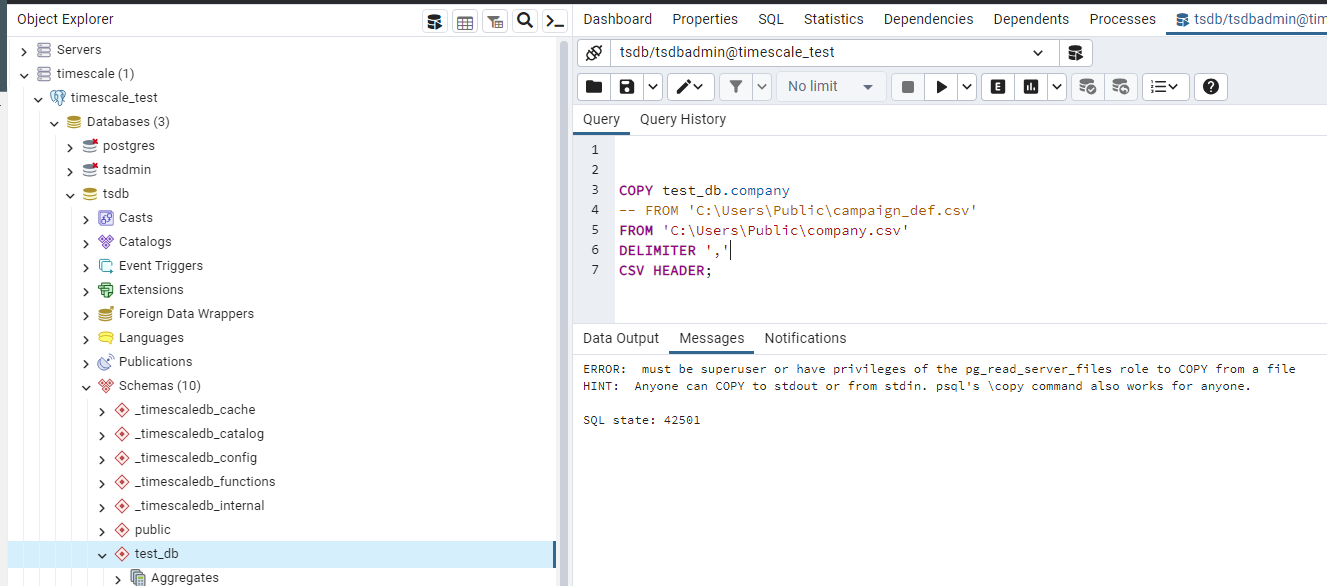

A direct methodology would be to loop over every table row/tuple with a SQL INSERT, I tried that also but the performance was poor. Snippet here:

In [ ]:
# https://www.psycopg.org/docs/cursor.html

# import csv
# with open('./tables/tick.csv', 'r') as f:
#     reader = csv.reader(f)
#     next(reader) # Skip the header row.
#     for row in reader:
#         row = str(row).replace("[","(").replace("]",")")
#         # the argument as concatenated strings, I've read this has issues when using f-strings. 
#         cursor.execute("INSERT INTO test_db.stock VALUES " + str(row) + ";")

I finally went ahead with installing and using the psql command line, the only quick alternative that had no timeline permission restrictions. 

We write 2 CSVs files into the database, in order to test the tool, without all the presetting.
<br>
The CSVs are proportioned by the official documentation. https://docs.timescale.com/use-timescale/latest/ingest-data/import-csv/ 

In [ ]:
schema_query =\
'''
    DROP SCHEMA IF EXISTS test_db CASCADE;
    CREATE SCHEMA test_db;
'''
cursor.execute(schema_query)


In [4]:
company_table = \
'''
CREATE TABLE IF NOT EXISTS test_db.company (
    symbol TEXT NOT NULL PRIMARY KEY,
    name TEXT NOT NULL
);
'''
cursor.execute(company_table)
cursor.execute("SELECT * FROM test_db.company;")
print(cursor.fetchall()) #returns empty company table

[]


In [16]:
stock_table = \
'''
CREATE TABLE IF NOT EXISTS test_db.stock (
    time TIMESTAMPTZ NOT NULL,
    symbol TEXT NOT NULL,
    price DOUBLE PRECISION NOT NULL,
    day_volume DOUBLE PRECISION NOT NULL,
    CONSTRAINT fk_symbol
        FOREIGN KEY(symbol)
            REFERENCES test_db.company(symbol)
            ON DELETE SET NULL
);
'''
cursor.execute(stock_table)
cursor.execute("SELECT * FROM test_db.stock;")
print(cursor.fetchall()) #returns empty stock table

[]


A HYPERTABLE must be defined prior uploading data to it. 

In [ ]:
cursor.execute('''
    SELECT create_hypertable('test_db.stock','time')
    -- table name , and then column name
''')

In [18]:
# check for new tables creation
cursor.execute('''
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'test_db'
    ORDER BY table_name;
''')
print(cursor.fetchall()) 

[('company',), ('stock',)]


We can also see this in the Timescale service, explorer tab.

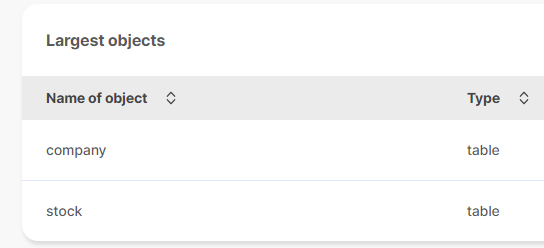

In [19]:
cursor.execute('''
    SELECT COLUMN_NAME
    FROM information_schema.COLUMNS
    WHERE TABLE_NAME = 'company';
''')
print(cursor.fetchall()) 

[('symbol',), ('name',)]


Using psql and COPY data is inserted to those table from "company.csv" and "tick_noNulls.csv". This last file is a modification of the original one, using pandas (stock_transformation.ipynb), to fill the null values in the last column; otherwise, I could not uploaded beacuses of data type compatibility error. 
<br>
Psql Command line screenshot:

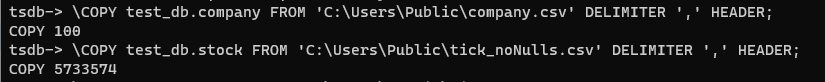

In [20]:
cursor.execute('''
    SELECT COUNT(*)
    FROM test_db.company
''')
print(cursor.fetchall()) 

[(100,)]


In [23]:
cursor.execute('''
    SELECT COUNT(*)
    FROM test_db.stock
''')
print(cursor.fetchall()) 

[(5733574,)]


####  END SESSION

In [22]:
# commit changes to the database to make changes persistent
conn.commit()

In [24]:
# close cursor to end session and release resources.
cursor.close()

#### POTENTIAL DATABASE SCHEMA FOR OUR STUDY CASE

Every company I've worked for has already used or migrated to a star-schema with tables correctly mapped to fact or dimension type.
<br>
When data scales, using a snowflake schema is the classic way to go due to the need for intermediate tables to further categorize the data.. Eg a product vs product_category, brand vs sub-brand.

I don't have enough context about the sample data we used in the above cells; additionally, the tables here were quite simple, but a common financial snow flake schema would be something like here below:

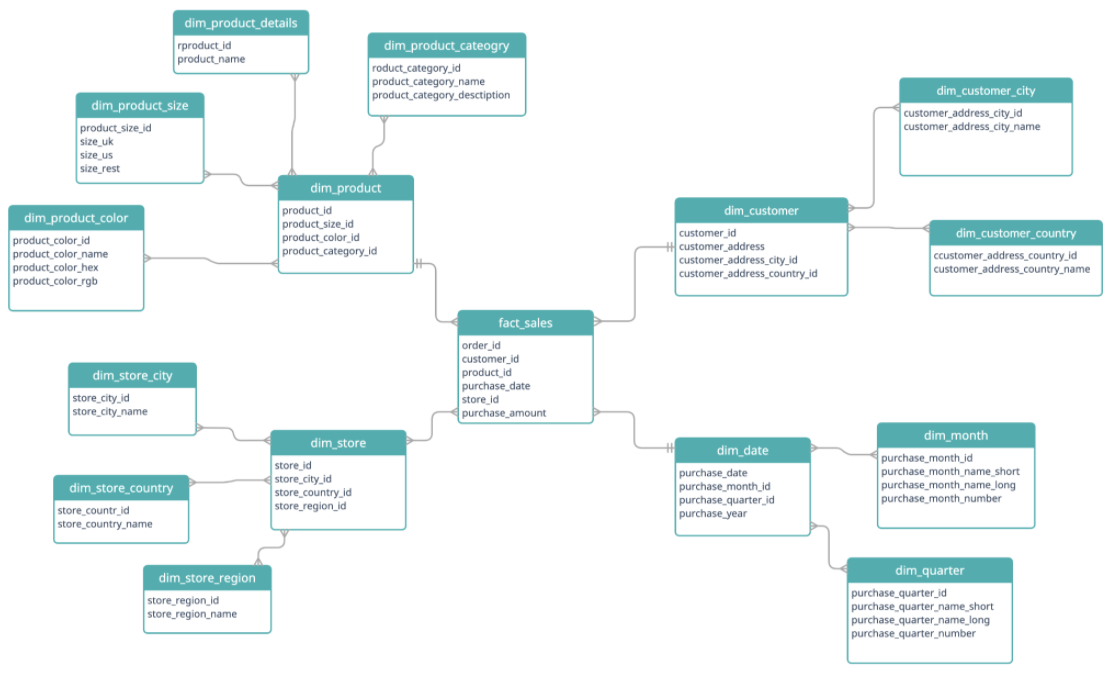